In [1]:
import itertools
import numpy as np
import pandas as pd 
from numbers import Number
import sqlite3
from scipy import stats
from scipy.stats import pearsonr
from scipy.stats import linregress
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')
import gzip
import pickle
import pandasql
import decimal

In [2]:
path = 'zippedData/im.db'
conn = sqlite3.connect(path)

cur = conn.cursor()
cur.execute("""SELECT name FROM sqlite_master WHERE type = 'table';""")

table_names = cur.fetchall() # Fetch the result and store it in table_names
table_names

[('movie_basics',),
 ('directors',),
 ('known_for',),
 ('movie_akas',),
 ('movie_ratings',),
 ('persons',),
 ('principals',),
 ('writers',)]

In [3]:
movie_gross = pd.read_csv('zippedData/bom.movie_gross.csv.gz')
movie_info = pd.read_table('zippedData/rt.movie_info.tsv.gz')
rt_reviews = pd.read_table('zippedData/rt.reviews.tsv.gz', encoding='unicode_escape')
tmdb_movies = pd.read_csv('zippedData/tmdb.movies.csv.gz')
movie_budgets = pd.read_csv('zippedData/tn.movie_budgets.csv.gz')

In [4]:
with gzip.open('zippedData/tmdb.movies.csv.gz', 'rb') as f:
    tmdb_movies = pd.read_csv(f)

for col in tmdb_movies.select_dtypes(include=['object']):
    tmdb_movies[col] = tmdb_movies[col].str.lower()

tmdb_movies = tmdb_movies.rename(columns={'original_title': 'movie'})
tmdb_movies['genre_ids'] = tmdb_movies['genre_ids'].str.replace('[', '').str.replace(']', '')

tmdb_moviesCLEAN = tmdb_movies.applymap(lambda x: str(x).replace(',', '').replace('$', ''))

# Define a dictionary to map genre ID numbers to genre names
genre_id_mapping = {
    '28': 'action',
    '12': 'adventure',
    '16': 'animation',
    '35': 'comedy',
    '80': 'crime',
    '99': 'documentary',
    '18': 'drama',
    '10751': 'family',
    '14': 'fantasy',
    '36': 'history',
    '27': 'horror',
    '10402': 'music',
    '9648': 'mystery',
    '878': 'science fiction',
    '10770': 'tv movie',
    '53': 'thriller',
    '10752': 'war',
    '37': 'western'
}

# Replace genre ID numbers with genre names in the 'genre_ids' column
for genre_id, genre_name in genre_id_mapping.items():
    tmdb_moviesCLEAN['genre_ids'] = tmdb_moviesCLEAN['genre_ids'].str.replace(genre_id, genre_name)
tmdb_moviesCLEAN.rename(columns={'movie': 'movieNAME'}, inplace=True)
tmdb_moviesCLEAN

,Unnamed: 0,genre_ids,id,original_language,movieNAME,popularity,release_date,title,vote_average,vote_count
0,0,adventure fantasy family,12444,en,harry potter and the deathly hallows: part 1,33.533,2010-11-19,harry potter and the deathly hallows: part 1,7.7,10788
1,1,fantasy adventure animation family,10191,en,how to train your dragon,28.734,2010-03-26,how to train your dragon,7.7,7610
2,2,adventure action science fiction,10138,en,iron man 2,28.515,2010-05-07,iron man 2,6.8,12368
3,3,animation comedy family,862,en,toy story,28.005,1995-11-22,toy story,7.9,10174
4,4,action science fiction adventure,27205,en,inception,27.92,2010-07-16,inception,8.3,22186
...,...,...,...,...,...,...,...,...,...,...
26512,26512,horror drama,488143,en,laboratory conditions,0.6,2018-10-13,laboratory conditions,0.0,1
26513,26513,drama thriller,485975,en,_exhibit_84xxx_,0.6,2018-05-01,_exhibit_84xxx_,0.0,1
26514,26514,fantasy action adventure,381231,en,the last one,0.6,2018-10-01,the last one,0.0,1
26515,26515,family adventure action,366854,en,trailer made,0.6,2018-06-22,trailer made,0.0,1


In [5]:
GENRES7 = tmdb_moviesCLEAN[['movieNAME', 'genre_ids']].copy()
GENRES7

,movieNAME,genre_ids
0,harry potter and the deathly hallows: part 1,adventure fantasy family
1,how to train your dragon,fantasy adventure animation family
2,iron man 2,adventure action science fiction
3,toy story,animation comedy family
4,inception,action science fiction adventure
...,...,...
26512,laboratory conditions,horror drama
26513,_exhibit_84xxx_,drama thriller
26514,the last one,fantasy action adventure
26515,trailer made,family adventure action


In [6]:
genre_id_mapping8 = {
    '28': 'action',
    '12': 'adventure',
    '16': 'animation',
    '35': 'comedy',
    '80': 'crime',
    '99': 'documentary',
    '18': 'drama',
    '10751': 'family',
    '14': 'fantasy',
    '36': 'history',
    '27': 'horror',
    '10402': 'music',
    '9648': 'mystery',
    '878': 'science fiction',
    '10770': 'tv movie',
    '53': 'thriller',
    '10752': 'war',
    '37': 'western'
}

# Split the genre_ids column into a list of strings
GENRES7['genre_ids'] = GENRES7['genre_ids'].str.split('|')

# Add a new column for each genre in the mapping
for genre_id, genre_name in genre_id_mapping.items():
    GENRES7[genre_name] = GENRES7['genre_ids'].apply(lambda x: genre_id in x).astype(int)
GENRES7

,movieNAME,genre_ids,action,adventure,animation,comedy,crime,documentary,drama,family,fantasy,history,horror,music,mystery,science fiction,tv movie,thriller,war,western
0,harry potter and the deathly hallows: part 1,[adventure fantasy family],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,how to train your dragon,[fantasy adventure animation family],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,iron man 2,[adventure action science fiction],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,toy story,[animation comedy family],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,inception,[action science fiction adventure],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26512,laboratory conditions,[horror drama],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
26513,_exhibit_84xxx_,[drama thriller],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
26514,the last one,[fantasy action adventure],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
26515,trailer made,[family adventure action],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [7]:
GENRES7['genre_ids'] = GENRES7['genre_ids'].astype(str).str.replace('[','').str.replace(']','').str.replace(' ','|').str.replace("'", "").str.replace(",", "")
GENRES7

,movieNAME,genre_ids,action,adventure,animation,comedy,crime,documentary,drama,family,fantasy,history,horror,music,mystery,science fiction,tv movie,thriller,war,western
0,harry potter and the deathly hallows: part 1,adventure|fantasy|family,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,how to train your dragon,fantasy|adventure|animation|family,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,iron man 2,adventure|action|science|fiction,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,toy story,animation|comedy|family,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,inception,action|science|fiction|adventure,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26512,laboratory conditions,horror|drama,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
26513,_exhibit_84xxx_,drama|thriller,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
26514,the last one,fantasy|action|adventure,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
26515,trailer made,family|adventure|action,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [8]:
def count_genres(genre_string):
    if genre_string is None:
        return 0
    else:
        return genre_string.count('|') + 1

GENRES7['genre_total'] = GENRES7['genre_ids'].apply(count_genres)
GENRES7

,movieNAME,genre_ids,action,adventure,animation,comedy,crime,documentary,drama,family,...,history,horror,music,mystery,science fiction,tv movie,thriller,war,western,genre_total
0,harry potter and the deathly hallows: part 1,adventure|fantasy|family,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
1,how to train your dragon,fantasy|adventure|animation|family,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4
2,iron man 2,adventure|action|science|fiction,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4
3,toy story,animation|comedy|family,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
4,inception,action|science|fiction|adventure,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26512,laboratory conditions,horror|drama,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
26513,_exhibit_84xxx_,drama|thriller,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
26514,the last one,fantasy|action|adventure,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
26515,trailer made,family|adventure|action,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3


In [9]:
GENRES7['genre_ids'] = GENRES7['genre_ids'].str.split('|')

# Iterate over the genre columns and transport the genre string values
for genre_id, genre_name in genre_id_mapping.items():
    GENRES7[genre_name] = 0
    GENRES7.loc[GENRES7['genre_ids'].apply(lambda x: genre_id in x), genre_name] = 1
GENRES7  

,movieNAME,genre_ids,action,adventure,animation,comedy,crime,documentary,drama,family,...,history,horror,music,mystery,science fiction,tv movie,thriller,war,western,genre_total
0,harry potter and the deathly hallows: part 1,"[adventure, fantasy, family]",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
1,how to train your dragon,"[fantasy, adventure, animation, family]",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4
2,iron man 2,"[adventure, action, science, fiction]",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4
3,toy story,"[animation, comedy, family]",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
4,inception,"[action, science, fiction, adventure]",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26512,laboratory conditions,"[horror, drama]",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
26513,_exhibit_84xxx_,"[drama, thriller]",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
26514,the last one,"[fantasy, action, adventure]",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
26515,trailer made,"[family, adventure, action]",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3


In [10]:
GENRES88=GENRES7
GENRES88

,movieNAME,genre_ids,action,adventure,animation,comedy,crime,documentary,drama,family,...,history,horror,music,mystery,science fiction,tv movie,thriller,war,western,genre_total
0,harry potter and the deathly hallows: part 1,"[adventure, fantasy, family]",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
1,how to train your dragon,"[fantasy, adventure, animation, family]",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4
2,iron man 2,"[adventure, action, science, fiction]",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4
3,toy story,"[animation, comedy, family]",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
4,inception,"[action, science, fiction, adventure]",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26512,laboratory conditions,"[horror, drama]",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
26513,_exhibit_84xxx_,"[drama, thriller]",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
26514,the last one,"[fantasy, action, adventure]",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
26515,trailer made,"[family, adventure, action]",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3


In [11]:
genre_order = ['action', 'adventure', 'animation', 'comedy', 'crime', 'documentary', 'drama', 'family', 'fantasy', 'history', 'horror', 'music', 'mystery', 'science fiction', 'tv movie', 'thriller', 'war', 'western']

# Create a dictionary to map genre names to integer values
genre_int_mapping = {genre_name: index+1 for index, genre_name in enumerate(genre_order)}

# Iterate over the genre columns and assign integer values based on the substring in the genre_ids column
for genre_name in genre_order:
    GENRES7[genre_name] = 0

for index, row in GENRES7.iterrows():
    genre_list = row['genre_ids']
    for genre in genre_list:
        if genre in genre_int_mapping:
            genre_int = genre_int_mapping[genre]
            genre_name = genre_order[genre_int-1]
            GENRES7.at[index, genre_name] = genre_int
GENRES7

,movieNAME,genre_ids,action,adventure,animation,comedy,crime,documentary,drama,family,...,history,horror,music,mystery,science fiction,tv movie,thriller,war,western,genre_total
0,harry potter and the deathly hallows: part 1,"[adventure, fantasy, family]",0,2,0,0,0,0,0,8,...,0,0,0,0,0,0,0,0,0,3
1,how to train your dragon,"[fantasy, adventure, animation, family]",0,2,3,0,0,0,0,8,...,0,0,0,0,0,0,0,0,0,4
2,iron man 2,"[adventure, action, science, fiction]",1,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4
3,toy story,"[animation, comedy, family]",0,0,3,4,0,0,0,8,...,0,0,0,0,0,0,0,0,0,3
4,inception,"[action, science, fiction, adventure]",1,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26512,laboratory conditions,"[horror, drama]",0,0,0,0,0,0,7,0,...,0,11,0,0,0,0,0,0,0,2
26513,_exhibit_84xxx_,"[drama, thriller]",0,0,0,0,0,0,7,0,...,0,0,0,0,0,0,16,0,0,2
26514,the last one,"[fantasy, action, adventure]",1,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
26515,trailer made,"[family, adventure, action]",1,2,0,0,0,0,0,8,...,0,0,0,0,0,0,0,0,0,3


In [12]:
GENRES7 = GENRES7.drop_duplicates(subset='movieNAME', keep='first')
GENRES7

,movieNAME,genre_ids,action,adventure,animation,comedy,crime,documentary,drama,family,...,history,horror,music,mystery,science fiction,tv movie,thriller,war,western,genre_total
0,harry potter and the deathly hallows: part 1,"[adventure, fantasy, family]",0,2,0,0,0,0,0,8,...,0,0,0,0,0,0,0,0,0,3
1,how to train your dragon,"[fantasy, adventure, animation, family]",0,2,3,0,0,0,0,8,...,0,0,0,0,0,0,0,0,0,4
2,iron man 2,"[adventure, action, science, fiction]",1,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4
3,toy story,"[animation, comedy, family]",0,0,3,4,0,0,0,8,...,0,0,0,0,0,0,0,0,0,3
4,inception,"[action, science, fiction, adventure]",1,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26512,laboratory conditions,"[horror, drama]",0,0,0,0,0,0,7,0,...,0,11,0,0,0,0,0,0,0,2
26513,_exhibit_84xxx_,"[drama, thriller]",0,0,0,0,0,0,7,0,...,0,0,0,0,0,0,16,0,0,2
26514,the last one,"[fantasy, action, adventure]",1,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
26515,trailer made,"[family, adventure, action]",1,2,0,0,0,0,0,8,...,0,0,0,0,0,0,0,0,0,3


In [13]:
GENRES7 = GENRES7.reset_index(drop=True)
GENRES7.columns

Index(['movieNAME', 'genre_ids', 'action', 'adventure', 'animation', 'comedy',
       'crime', 'documentary', 'drama', 'family', 'fantasy', 'history',
       'horror', 'music', 'mystery', 'science fiction', 'tv movie', 'thriller',
       'war', 'western', 'genre_total'],
      dtype='object')

In [14]:
genre_columns = ['action', 'adventure', 'animation', 'comedy', 'crime', 'documentary', 'drama', 'family', 'fantasy', 'history', 'horror', 'music', 'mystery', 'science fiction', 'tv movie', 'war', 'western']
new_GENRES= GENRES7[genre_columns]
new_GENRES

,action,adventure,animation,comedy,crime,documentary,drama,family,fantasy,history,horror,music,mystery,science fiction,tv movie,war,western
0,0,2,0,0,0,0,0,8,9,0,0,0,0,0,0,0,0
1,0,2,3,0,0,0,0,8,9,0,0,0,0,0,0,0,0
2,1,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,3,4,0,0,0,8,0,0,0,0,0,0,0,0,0
4,1,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24813,0,0,0,0,0,0,7,0,0,0,11,0,0,0,0,0,0
24814,0,0,0,0,0,0,7,0,0,0,0,0,0,0,0,0,0
24815,1,2,0,0,0,0,0,0,9,0,0,0,0,0,0,0,0
24816,1,2,0,0,0,0,0,8,0,0,0,0,0,0,0,0,0


In [15]:
columns_to_plot = [col for col in new_GENRES.columns if new_GENRES[col].sum() > 0]
genres_to_plot = new_GENRES[columns_to_plot].sum().reset_index()
genres_to_plot.columns = ['genre', 'count']
genres_to_plot

,genre,count
0,action,2469
1,adventure,2592
2,animation,4248
3,comedy,21356
4,crime,6810
5,documentary,28242
6,drama,52563
7,family,12000
8,fantasy,9468
9,history,5610


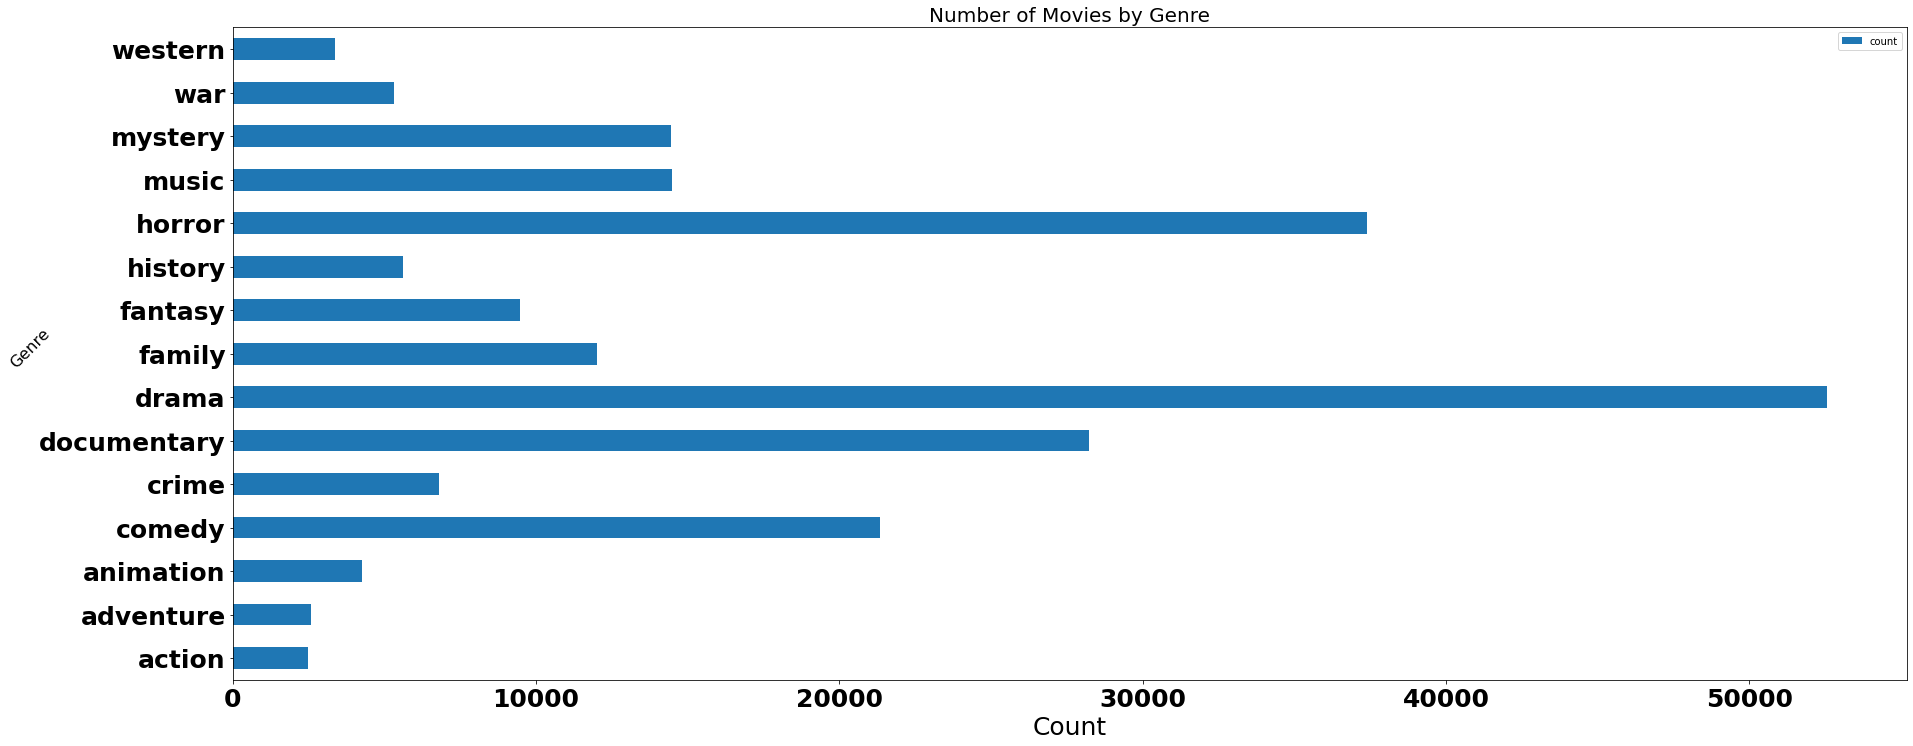

In [16]:
fig, ax = plt.subplots(figsize=(30, 12))  # Swap the figsize dimensions

# Use horizontal bar plot instead of vertical bar plot
genres_to_plot.plot.barh(y='count', x='genre', ax=ax, rot=0)

# Set the axis labels and title
ax.set_xlabel("Count", fontsize=25)  # Swap x and y labels
ax.set_ylabel("Genre", fontsize=25)  # Swap x and y labels
ax.set_ylabel("Genre", fontsize=16, rotation=45)

ax.set_title("Number of Movies by Genre", fontsize=20)

# Set the tick label font size
plt.xticks(fontsize=25, fontweight='bold')
plt.yticks(fontsize=25, fontweight='bold')

# Show the chart
plt.show()